# SELECTING HUMAN TRANSCRIPTS (VERSION 2)
October 25, 2020

Here we explain our strategy in building the second version of the RiboFlow human transcript.

We revisit our reference building strategy using the most recent (as of the writing of this document) version of [APPRIS](http://appris-tools.org/) principal isoforms. 
In particular, our appris list uses GENCODE [Release 34](https://www.gencodegenes.org/human/release_34.html).

While we followed our former strategy, we decided to make slight modifications to make our transcript picking method more inclusive. Namely, in the new version we allow transcripts to have empty (5' or 3') UTRs. 

In [1]:
! ls ..

raw  riboflow_annot_and_ref  scripts


In [2]:
# PYTHON MODULES
import sys
import os
from collections import defaultdict
import gzip

import matplotlib
from matplotlib_venn import venn2, venn2_unweighted
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from IPython.display import Markdown as md
from IPython.core.display import HTML as Center
from IPython.display import display_html


sys.path.insert(0, '../../../..')
import ref_lib
from ref_lib.Fasta import FastaFile, FastaEntry
from ref_lib.GTF import GTFfile, GTFEntry, get_gtf_contents

%matplotlib inline

import IPython

# Some formatting forthe rest of the notebook
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Reference and annotations files we'll be using:

In [3]:
transcripts_fasta = "../raw/sequence/gencode.v34.pc_transcripts.fa.gz"
gencode_gtf       = "../raw/annotation/gencode.v34.annotation.gtf.gz"
appris_file       = "../raw/annotation/appris_data.principal.txt.gz"

GENCODE gtf contents are stored in a dictionary. It might take a while to read all gtf:

In [4]:
gtf_all = get_gtf_contents( gencode_gtf )

In [5]:
gtf_all["ENSG00000111640"]['ENST00000619601']

{'exons': [(6536605, 6536607),
  (6536684, 6536790),
  (6536920, 6537010),
  (6537101, 6537216),
  (6537309, 6537390),
  (6537584, 6537996),
  (6538101, 6538374)],
 'CDS': [(6536605, 6536607, 0),
  (6536684, 6536790, 1),
  (6536920, 6537010, 2),
  (6537101, 6537216, 3),
  (6537309, 6537390, 4),
  (6537584, 6537996, 5),
  (6538101, 6538167, 6)],
 'strand': '+',
 'start': 6536605,
 'end': 6538374,
 'gene_type': 'protein_coding',
 'length': 1086}

We define the functions to extract CDS and UTR coordinates relative ro the transcript start. These care stored in the gtf_all dictionary with "bed_" prefix.

In [6]:
def _find_rel_cds_end_coords( exon_list, cds_contents, coord_type, strand ):
    """
    Returns the start or end of the CDS 0-based bed format
    So the start position is included and end position is excluded
    """    
    # c is the corresponding_exon_index to the cds chunk
    
    if coord_type == "start":
        cds_chunk = cds_contents[0]
        c = cds_chunk[2]
        if strand == "+":
            this_sum = cds_chunk[0] - exon_list[c][0]
        else:
            this_sum = exon_list[c][1] - cds_chunk[1]
    else:
        cds_chunk = cds_contents[-1]
        c = cds_chunk[2]
        this_sum = (cds_chunk[1] - cds_chunk[0]) + 1
        
        if len(cds_contents) == 1:
            if strand == "+":
                this_sum += cds_chunk[0]  - exon_list[c][0]  
            else:
                this_sum += exon_list[c][1] - cds_chunk[1]
        """
        Delete this later!!!
        if strand == "+":
            this_sum = (cds_chunk[1] - cds_chunk[0]) + 1
        else:
            this_sum = cds_chunk[0] - exon_list[c][0]
        """
    for e in exon_list[:c]:
        this_sum += (e[1] - e[0]) + 1
        
    return this_sum


def find_rel_utr_cds_positions( genes_dict ):
    """
    For each transcri,pt, the first nucleotide (of the transcript) has position 0
    the coordinates are in BED stye
    so For A,B 
    A: start, is INCLUDED
    B: end, is EXCLUDED
    The coordinates have the _bed prefix and they are stored in
    the corresponding transcript dictionary
    """
    # 
    # 0-based and end coordinate is excluded
    # 
    for g_name, transcripts in genes_dict.items():
    
        for t_name, t_contents in transcripts.items():
            CDS_contents = t_contents.get("CDS", list())
            if len(CDS_contents) == 0:
                continue

            cds_rel_start = \
                _find_rel_cds_end_coords( t_contents["exons"], CDS_contents, "start", t_contents["strand"]   )
            cds_rel_end = \
                _find_rel_cds_end_coords( t_contents["exons"], CDS_contents, "end", t_contents["strand"] )
        
            t_length = t_contents["length"]
                
            t_contents["bed_CDS"] = ( cds_rel_start, cds_rel_end )
            if cds_rel_start > 0:
                t_contents["bed_UTR_5"] = (0, cds_rel_start  )
                
            if cds_rel_end < t_length:
                t_contents["bed_UTR_3"] = (cds_rel_end, t_length )

In [7]:
find_rel_utr_cds_positions(gtf_all)

## Selecting Longest Appris Transcripts

When going through Appris transcripts, we pick only the ones labeled with the label "PRINCIPAL".

In [8]:
def read_principal_appris_trascript_list(appris_file, gtf_contents):
    """
    Reads the appris isoform file into a dictionary
    
    We assume that the files is of the form:
    Gene NAme \t GENE_ID \t TRANSCRIOPT_ID \t APPRIS_CATEGORY
    # C1orf112	ENSG00000000460	ENST00000286031	CCDS1285	PRINCIPAL:1
    
    The output dictionary is of the form:
    appris_genes[gene_id][transcript_id] = {  "gene_name": gene_name, "category": category }
    """
    
    appris_genes = defaultdict(dict)
    myopen=open
    if appris_file.endswith(".gz"):
        myopen = gzip.open
    
    with myopen(appris_file, "rt") as input_stream:
        for entry in input_stream:
            contents = entry.strip().split()
            if len(contents) < 5:
                continue
            gene_name, gene_id, transcript_id, dummy, category = contents
            if not category.startswith("PRINCIPAL"):
                continue
            appris_genes[gene_id][transcript_id] = gtf_contents[gene_id][transcript_id]
            
    return appris_genes

In [9]:
appris_principal_transcripts = read_principal_appris_trascript_list(appris_file, gtf_all)
len(appris_principal_transcripts)

20347

A gene may have more than one principal isoform. 
So we pick the longest transcript to list each gene only once.

In [10]:
def pick_longest_appris_transcripts( appris_genes ):
    longest_picks = defaultdict(dict)
    
    for gene, transcripts in appris_genes.items():
        g_transcripts = list( transcripts.items() )
        longest_transcript = g_transcripts[0]
        for t_name, t_contents in g_transcripts[1:]:
            if t_contents["length"] > longest_transcript[1]["length"]:
                longest_transcript = (t_name, t_contents)
        longest_picks[ gene ][longest_transcript[0]] = longest_transcript[1]   
    return longest_picks

In [11]:
longest_appris_transcripts = pick_longest_appris_transcripts(appris_principal_transcripts)
len(longest_appris_transcripts)

20347

## Protein Coding Transcripts

We are only interested in protein coding transcripts.

In [12]:
def pick_protein_coding_transcripts( transcript_dict ):
    protein_coding_longest_transcripts = defaultdict(dict)

    for g, transcripts in transcript_dict.items():
        for t_name , t_contents in transcripts.items():
            if t_contents["gene_type"] == "protein_coding":
                protein_coding_longest_transcripts[g][t_name] = t_contents

    return protein_coding_longest_transcripts

In [13]:
protein_coding_transcripts = pick_protein_coding_transcripts(longest_appris_transcripts)

##  Start & Stop Codons

We examine the start and stop codons of the Appris transcripts first. 
Then we select those having "prpoper" start and stop codons.

In [14]:
t_fasta_stream = FastaFile(transcripts_fasta)

clipped        = list()
start_triplets = defaultdict(int)
stop_triplets  = defaultdict(int)

for this_fasta_entry in t_fasta_stream:
    contents = this_fasta_entry.header.strip().split("|")
    this_t   = contents[0].split(".")[0]
    
    g_contents = contents[1].split(".")
    this_g     = g_contents[0]
    
    if len(g_contents) >= 2 and "PAR_Y" in g_contents[1]:
        continue
    
    transcripts = longest_appris_transcripts.get(this_g, None)
    
    if transcripts == None:
        continue
        
    if this_t in list(protein_coding_transcripts[this_g].keys()):
        bed_CDS = longest_appris_transcripts[this_g][this_t].get("bed_CDS", None)
        
        if bed_CDS != None:
            start_codon_coord = bed_CDS[0]
            start_triplets[ this_fasta_entry.sequence[ start_codon_coord:start_codon_coord+3 ]  ] += 1
            stop_triplets[ this_fasta_entry.sequence[ bed_CDS[1]:bed_CDS[1] + 3 ]  ] += 1

print("start_triplets:")
print(start_triplets)
print("---------------------------")
print("stop_triplets:")
print(stop_triplets)

start_triplets:
defaultdict(<class 'int'>, {'ATG': 19726, 'AGG': 3, 'GTG': 12, 'AAG': 10, 'ATA': 6, 'GCT': 4, 'GAA': 5, 'TGA': 4, 'CTG': 27, 'GGT': 2, 'GGG': 6, 'CTC': 2, 'GCG': 4, 'ACG': 4, 'GGA': 5, 'TTT': 2, 'AGT': 3, 'TAT': 3, 'CAG': 4, 'AGC': 5, 'CCT': 5, 'TTC': 2, 'GCC': 5, 'ACT': 6, 'GAG': 3, 'TTG': 4, 'ATC': 4, 'CCC': 2, 'ATT': 7, 'TCC': 7, 'AAC': 2, 'GTA': 2, 'CAC': 2, 'TAA': 1, 'AGA': 6, 'GCA': 2, 'TCT': 2, 'CTA': 1, 'CTT': 2, 'ACC': 2, 'CAA': 6, 'CGG': 3, 'GAT': 4, 'TTA': 1, 'GTC': 1, 'GTT': 1, 'TCA': 3, 'TGG': 2, 'CCA': 3, 'CGC': 3, 'ACA': 3, 'CCG': 2, 'GAC': 1, 'TAC': 1, 'CGT': 1, 'AAT': 1, 'GGC': 1})
---------------------------
stop_triplets:
defaultdict(<class 'int'>, {'TAG': 4436, 'TAA': 5626, 'TGA': 9783, '': 95, 'CAG': 1})


In [15]:
def pick_transcripts_with_proper_codons( appris_transcripts, fasta_file ):
    """
    Picks the transwcripts with proper start and stop codon
    """
    proper_picks = defaultdict(dict)
    
    # Proper start codons are those that are 1 nucleotide away
    # from ATG (in Hamming Distance)
    
    proper_start_codons = ["ATG", "CTG", "GTG", "TTG",
                           "AAG", "ACG", "AGG",
                           "ATA", "ATC", "ATT"]
    
    proper_stop_codons = ['TAG', "TAA", "TGA"]
    
    t_fasta_stream = FastaFile(fasta_file)
    
    for this_fasta_entry in t_fasta_stream:
        contents = this_fasta_entry.header.strip().split("|")
        this_t   = contents[0].split(".")[0]
    
        g_contents = contents[1].split(".")
        this_g     = g_contents[0]
    
        transcripts = appris_transcripts.get(this_g, None)
        
        if transcripts == None:
            continue
            
        if this_t not in list(appris_transcripts[this_g].keys()):
            continue
            
        bed_CDS = appris_transcripts[this_g][this_t].get("bed_CDS", None)
        
        
        
        if bed_CDS != None: 
            start_codon = this_fasta_entry.sequence[ bed_CDS[0] : bed_CDS[0] + 3 ]
            stop_codon  = this_fasta_entry.sequence[ bed_CDS[1] : bed_CDS[1] + 3 ]
            
            if not stop_codon:
                stop_codon  = this_fasta_entry.sequence[ bed_CDS[1] - 3 : bed_CDS[1] ]
                
            if start_codon in proper_start_codons and \
               stop_codon  in proper_stop_codons:
                proper_picks[this_g][this_t] = appris_transcripts[this_g][this_t]
             
    return proper_picks

In [16]:
transcripts_with_proper_codons = \
    pick_transcripts_with_proper_codons( \
        appris_transcripts = protein_coding_transcripts, 
        fasta_file         = transcripts_fasta )

In [17]:
t_fasta_stream = FastaFile(transcripts_fasta)

clipped        = list()
start_triplets = defaultdict(int)
stop_triplets  = defaultdict(int)

for this_fasta_entry in t_fasta_stream:
    contents = this_fasta_entry.header.strip().split("|")
    this_t   = contents[0].split(".")[0]
    
    g_contents = contents[1].split(".")
    this_g     = g_contents[0]
    
    if len(g_contents) >= 2 and "PAR_Y" in g_contents[1]:
        continue
    
    transcripts = transcripts_with_proper_codons.get(this_g, None)
    
    if transcripts == None:
        continue
        
    if this_t in list(transcripts_with_proper_codons[this_g].keys()):
        bed_CDS = longest_appris_transcripts[this_g][this_t].get("bed_CDS", None)
        
        if bed_CDS != None:
            start_codon_coord = bed_CDS[0]
            start_triplets[ this_fasta_entry.sequence[ start_codon_coord:start_codon_coord+3 ]  ] += 1
            
            stop_triplet = this_fasta_entry.sequence[ bed_CDS[1]:bed_CDS[1] + 3 ] 
            if not stop_triplet:
                stop_triplet = this_fasta_entry.sequence[ bed_CDS[1] -3 : bed_CDS[1] ] 
            stop_triplets[ stop_triplet ] += 1

print("start_triplets:")
print(start_triplets)
print("---------------------------")
print("stop_triplets:")
print(stop_triplets)

start_triplets:
defaultdict(<class 'int'>, {'ATG': 19663, 'AGG': 3, 'GTG': 12, 'AAG': 10, 'ATA': 4, 'CTG': 27, 'ACG': 4, 'TTG': 3, 'ATC': 4, 'ATT': 6})
---------------------------
stop_triplets:
defaultdict(<class 'int'>, {'TAG': 4419, 'TAA': 5605, 'TGA': 9712})


In [18]:
transcripts_with_proper_codons

defaultdict(dict,
            {'ENSG00000186092': {'ENST00000335137': {'exons': [(69055, 70108)],
               'CDS': [(69091, 70005, 0)],
               'strand': '+',
               'start': 69055,
               'end': 70108,
               'gene_type': 'protein_coding',
               'length': 1054,
               'bed_CDS': (36, 951),
               'bed_UTR_5': (0, 36),
               'bed_UTR_3': (951, 1054)}},
             'ENSG00000284733': {'ENST00000426406': {'exons': [(450703,
                 451697)],
               'CDS': [(450743, 451678, 0)],
               'strand': '-',
               'start': 450703,
               'end': 451697,
               'gene_type': 'protein_coding',
               'length': 995,
               'bed_CDS': (19, 955),
               'bed_UTR_5': (0, 19),
               'bed_UTR_3': (955, 995)}},
             'ENSG00000284662': {'ENST00000332831': {'exons': [(685679,
                 686673)],
               'CDS': [(685719, 686654, 0)],
   

## Selecting Transcripts

Now we finalize our selection in transcripts.
We set our transcripts to those with proper start and stop codons. 
Note that these transcripts come from a subset of protein coding transcripts.

In [19]:
selected_transcripts = transcripts_with_proper_codons

## Are CDS lengths divisible by 3?

In [20]:
CDS_remainder_by_3 = [0,0,0]
non_zero_remainder_transcripts = defaultdict(dict)

for g, transcripts in selected_transcripts.items():
    for t_name, t_contents in transcripts.items():
        bed_CDS = t_contents.get("bed_CDS", None)
        this_remainder = (bed_CDS[1] - bed_CDS[0]) % 3
        CDS_remainder_by_3[this_remainder] += 1
        if this_remainder != 0:
            non_zero_remainder_transcripts[g][t_name] = t_contents

print("CDS length divisible by 3: ", CDS_remainder_by_3[0])
print("CDS length NOT divisible by 3: ", CDS_remainder_by_3[1] + CDS_remainder_by_3[2])

CDS length divisible by 3:  19711
CDS length NOT divisible by 3:  25


## Length Distributions

Now we check the length distribution of CDS, 5' and 3' UTRS.

In [21]:
missing_utr5 = 0
missing_utr3 = 0
missing_cds  = 0

utr5_lengths = list()
utr3_lengths = list()
cds_lengths  = list()

for gene, contents in selected_transcripts.items():
    
    t_name     = tuple(contents.keys())[0]
    transcript = contents[t_name]
    #print(gene, t_name)
    utr_5 = transcript.get('bed_UTR_5')
    
    if utr_5:
        utr5_len = utr_5[1] - utr_5[0]
        
        if utr5_len <= 0:
            print("5'UTR length of {} is {}".format(t_name, utr5_len))
    else:
        print("{} of {} doesn't have annotated UTR_5".format(t_name, gene))
        missing_utr5 += 1
        utr5_len      = 0
    
    utr5_lengths.append(utr5_len)
    
    utr_3 = transcript.get('bed_UTR_3')
    
    if utr_3:
        utr3_len = utr_3[1] - utr_3[0]
        
        if utr3_len <= 0:
            print("3'UTR length of {} is {}".format(t_name, utr3_len))
    else:
        print("{} of {} doesn't have annotated UTR_3".format(t_name, gene))
        missing_utr3 += 1
        utr3_len      = 0
        
    utr3_lengths.append(utr3_len)
        
    cds_length = transcript["bed_CDS"][1] - transcript["bed_CDS"][0]
    cds_lengths.append(cds_length)
    
    if cds_length == 0:
        missing_cds += 1
        
print("------------------------------------------------------")
print("There are {} genes with missing 5' UTR".format(missing_utr5))
print("There are {} genes with missing 3' UTR".format(missing_utr3))
print("There are {} genes with missing CDS".format(missing_cds))

ENST00000433179 of ENSG00000187642 doesn't have annotated UTR_5
ENST00000378821 of ENSG00000205116 doesn't have annotated UTR_5
ENST00000400906 of ENSG00000197241 doesn't have annotated UTR_5
ENST00000377004 of ENSG00000175262 doesn't have annotated UTR_5
ENST00000433342 of ENSG00000215910 doesn't have annotated UTR_5
ENST00000376221 of ENSG00000204518 doesn't have annotated UTR_5
ENST00000624297 of ENSG00000279804 doesn't have annotated UTR_5
ENST00000376101 of ENSG00000204480 doesn't have annotated UTR_5
ENST00000345034 of ENSG00000215695 doesn't have annotated UTR_5
ENST00000400664 of ENSG00000179023 doesn't have annotated UTR_5
ENST00000602384 of ENSG00000270136 doesn't have annotated UTR_5
ENST00000634879 of ENSG00000075151 doesn't have annotated UTR_5
ENST00000426928 of ENSG00000215906 doesn't have annotated UTR_5
ENST00000527604 of ENSG00000255054 doesn't have annotated UTR_5
ENST00000409358 of ENSG00000222046 doesn't have annotated UTR_5
ENST00000373456 of ENSG00000116514 doesn

In [22]:
median_cds_length = int(np.median(cds_lengths))
mean_cds_length   = int(np.mean(cds_lengths))

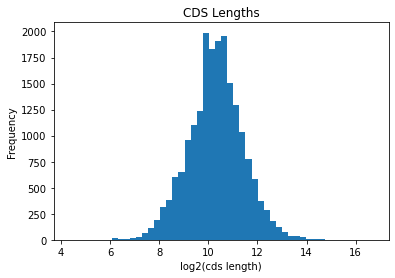

In [23]:
plt.hist(np.log2(np.array(cds_lengths) ), bins = 50);
plt.xlabel("log2(cds length)");
plt.ylabel("Frequency");
plt.title("CDS Lengths");

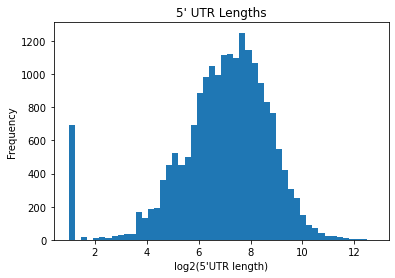

In [24]:
plt.hist(np.log2(np.array(utr5_lengths) + 2 ), bins = 50);
plt.xlabel("log2(5'UTR length)");
plt.ylabel("Frequency");
plt.title("5' UTR Lengths");

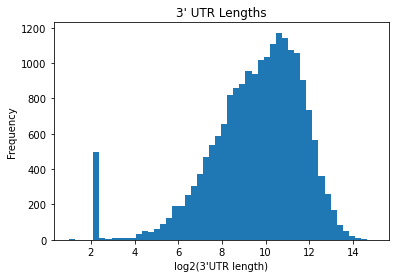

In [25]:
plt.hist(np.log2(np.array(utr3_lengths) + 2 ), bins = 50);
plt.xlabel("log2(3'UTR length)");
plt.ylabel("Frequency");
plt.title("3' UTR Lengths");

## Summary


We explored [Appris](https://academic.oup.com/nar/article/46/D1/D213/4561658) transcripts. Based on our observations, we decided to filter out some transcripts for our purposes. In particular, we followed the following steps:

1. We picked only "PRINCIPAL" entries and left "ALTERNATIVE" entries.
2. We picked only protein coding genes by choosing "gene_type protein_coding" in the GTF file.
3. We picked transcripts with the  *proper*\* start / stop codons.

These steps are mostly based on our 'Sanity Checks'.

Also, we discard Y chromosome paralogs of genes. They have "PAR_Y" in their gene ID in the gtf file and the fasta file

After filtering, we had a total of **{{ len(selected_transcripts) }} transcripts**.

* {{CDS_remainder_by_3[0]}} of these transcripts have CDS with length a multiple of 3. Whereas {{CDS_remainder_by_3[1] + CDS_remainder_by_3[2]}} of them don't.

* {{ start_triplets['ATG'] }} of them start with ATG (the start codon)

* The median length of the CDS regions is {{ median_cds_length }}. The average length is {{ mean_cds_length }}. This is consistent with the median length of human proteins reported in earlier studies.

* There are {{ missing_utr5 }} transcripts missing 5' UTR and {{ missing_utr3 }} transcripts missing 3' UTR.

* In the Appris list, different transcripts of the same gene have identical sequences. There are a few exceptions to this. Even those excpetional cases differ in ~1 nucleotide position. This doesn't effect the mapping results significantly. Therefore, in case there are multiple principal isoform entries of the same gene, picking one arbitrarily doesn't make a noticeable difference.

--------------
\*Proper start codons are those that are 1 nucleotide away from the codon ATG.

## Files and Hash Sums

Appris Version 2020_06.v32

Appris list was downloaded from : http://appris-tools.org/#/downloads
on October 7, 2020

GENCODE:

All other files have been downloaded from gencode website: [https://www.gencodegenes.org/human/](https://www.gencodegenes.org/human/)

Version: Release 34 (GRCh38.p13)

In [26]:
! zcat  ../raw/sequence/gencode.v34.pc_transcripts.fa.gz | md5sum

d6282ee20ba40647fa8f2381e44ccef3  -


In [27]:
! zcat ../raw/annotation/gencode.v34.annotation.gtf.gz | md5sum

7dad6018f44e8bc5921c3aa3e78b9a7d  -


In [28]:
! zcat ../raw/annotation/appris_data.principal.txt.gz | md5sum

894592df6d46ef8fb4d77e47c8010bef  -


## Generating RiboFlow Reference and Annotation

If the riboflow reference and annotation has not already been generated, you can run the 'generate_riboflow_ref_and_annot.sh' inside the scripts folder.

## Comparison with the Previous RiboFlow Reference Version

**Convention:**  
*v1* refers to the first, aka previous, reference used in RiboFlow.  
*v2* refers to the second, aka current = this, reference used in RiboFlow.

We compare the genes in v2 to those in v1. The two references agree on most genes. 
As for the genes that don't exist in etiher of v1 and v2, most of such genes have low expression values in the GTEX table. 

In [29]:
previous_fasta_path = "../../v1/riboflow_annot_and_ref/appris_human_v1_selected.fa.gz"
previous_fasta_path = os.path.abspath(previous_fasta_path)

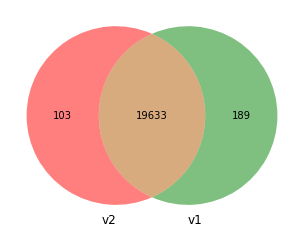

In [30]:
previous_fasta_file = FastaFile(previous_fasta_path)

prev_transcript_id_name_pairs = list()
prev_transcript_names         = list()
prev_gene_ids         = list()

for f in previous_fasta_file:
    contents = f.header.split("|")
    prev_transcript_id_name_pairs.append( (contents[0], contents[4]) )
    prev_transcript_names.append(contents[4])
    prev_gene_ids.append( contents[1].split(".")[0] )
    
current_gene_ids  = list(selected_transcripts.keys() )
current_gene_set  = set(current_gene_ids)
previous_gene_set = set(prev_gene_ids) 

current_minus_prev_genes = current_gene_set - previous_gene_set
prev_minus_current_genes = previous_gene_set - current_gene_set

venn2_unweighted( [current_gene_set, previous_gene_set], 
                   set_labels = ('v2', 'v1'), 
                   alpha      = 0.5);

### What are the genes missing from v2?

We investigate the genes that are excluded from our current list. Note that these genes were in v1.

First we look these up in GTEX expression table. We report the minimum, median and maximum expression of these genes and their corresponding tissues.

In [31]:
gtex_path = "../raw/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.tsv.gz"
gtex_tpm  = pd.read_csv(gtex_path, sep = "\t", header = 0, index_col = 0 )

# Remove version numbers in the gene identifiers
new_gtex_index = tuple( map(lambda x: x.split(".")[0], gtex_tpm.index) )
gtex_tpm.index = new_gtex_index

In [32]:
# Subset gtex to our genes of interest
gtex_missing_from_v2 = \
    gtex_tpm.loc[ [ (x in prev_minus_current_genes) for x in gtex_tpm.index] , :]

In [33]:
def process_gtex_row(gene_tpms):
    actual_tpms = np.array( gene_tpms[1:] )
    median_gene = gtex_missing_from_v2.columns[ np.argsort(actual_tpms)[len(actual_tpms)//2] + 1 ]
    min_gene    = gtex_missing_from_v2.columns[ np.argmin(actual_tpms) +1 ]
    max_gene    = gtex_missing_from_v2.columns[ np.argmax(actual_tpms) +1 ]
    return (gene_tpms[0], 
            np.median(actual_tpms), np.min(actual_tpms), np.max(actual_tpms),
            median_gene, min_gene, max_gene)

gtex_v2_table = gtex_missing_from_v2.apply( 
                     process_gtex_row, 
                     axis        = 1, 
                     result_type = 'expand' )

gtex_v2_table.rename(columns = {0: "gene", 1: "Median TPM", 2: "Min TPM", 3: "Max TPM",
                                4: "Median Tis.", 5: "Min Tis.", 6: "Max Tis." },
                     inplace = True)

display_html("<center><b>Genes in v1 - v2</b><br>{} genes</center>".format(len(gtex_v2_table) ), raw = True)
gtex_v2_table.sort_values(by = "Median TPM", ascending = False)

Genes in v1 - v2 57 genes

,gene,Median TPM,Min TPM,Max TPM,Median Tis.,Min Tis.,Max Tis.
ENSG00000204387,C6orf48,105.937500,18.311500,523.927000,Colon - Sigmoid,Heart - Left Ventricle,Ovary
ENSG00000241978,AKAP2,20.395150,1.224960,196.590000,Vagina,Whole Blood,Cells - Cultured fibroblasts
ENSG00000093144,ECHDC1,18.499600,7.255170,41.190900,Ovary,Whole Blood,Cells - Cultured fibroblasts
ENSG00000163602,RYBP,14.092900,3.002770,28.216200,Colon - Transverse,Heart - Left Ventricle,Uterus
ENSG00000130489,SCO2,12.609100,3.999340,32.352600,Esophagus - Muscularis,Brain - Putamen (basal ganglia),Cells - EBV-transformed lymphocytes
ENSG00000183688,RFLNB,10.738200,1.883180,47.545300,Skin - Sun Exposed (Lower leg),Liver,Whole Blood
ENSG00000184208,C22orf46,10.733900,1.460070,58.235500,Spleen,Whole Blood,Brain - Spinal cord (cervical c-1)
ENSG00000196312,MFSD14C,7.335725,1.775850,16.266100,Stomach,Heart - Left Ventricle,Artery - Aorta
ENSG00000167920,TMEM99,7.168645,1.053230,97.691800,Adipose - Visceral (Omentum),Whole Blood,Testis
ENSG00000204152,TIMM23B,6.875420,0.895927,10.192200,Brain - Cerebellar Hemisphere,Whole Blood,Nerve - Tibial


The above table is sorted by Median TPMs. We obtained "Median TPMs" column by taking the median value across tissue types. The first 12 entries have relatively higher values of TPMS. So we take a closer look.

**C6orf48:**  
SNHG32 (Small Nucleolar RNA Host Gene 32) is an RNA Gene, and is affiliated with the lncRNA class. Diseases associated with SNHG32 include Acute Diarrhea. 

This gene was marked as "protein coding" in v29 but it was marked as "lncRNA" in v34.

-------------

**AKAP2:**  
Binds to regulatory subunit (RII) of protein kinase A. May be involved in establishing polarity in signaling systems or in integrating PKA-RII isoforms with downstream effectors to capture, amplify and focus diffuse, trans-cellular signals carried by cAMP. 

This was removed in the current APPRIS list.

--------------

**ECHDC1:**
    
This transcript is missing both the proper start and stop codons.

--------------

**RYBP:**
    
This transcript is missing the proper start codon.

--------------

**SCO2:**  
Copper metallochaperone essential for the synthesis and maturation of cytochrome c oxidase subunit II (MT-CO2/COX2). Involved in transporting copper to the Cu(A) site on MT-CO2/COX2 (PubMed:15229189, PubMed:17189203). Also acts as a thiol-disulfide oxidoreductase to regulate the redox state of the cysteines in SCO1 during maturation of MT-CO2/COX2 (PubMed:19336478)

This gene (ENSG00000130489) was removed from the new Appris list. Though it existed in the previous version.


-------------

**RFLNB:**

This transcript is missing the proper start codon.    
    
--------------

**C22orf46:**  
C22orf46 (Chromosome 22 Open Reading Frame 46) is a Pseudogene.

This has been remved from the new Apris list.

-------------

**MFSD14C:**  

This has been removed from the Apris list.

-------------

**TMEM99:**  

This is removed from the Apris list. Also, it is marked as "lncRNA" in the new Gencode annotation.

----------------

**TIMM23B:**  

This is removed from the Apris list. Also it is marked as "transcribed_unprocessed_pseudogene" in the new Gencode annotation.
 
**RP11-192H23.4 (AC005726.1):**  
Its principal isoform has changed and it has no 5' UTR in the new annotation.
ENST00000577790 -> ENST00000531839

-----------------

**C17orf51:**  

This is removed from the Apris list. Also it is marked as "lncRNA" in the new Gencode annotation.

### How about the genes not in GTEX table?

We also give a list of genes not in the GTEX table.


In [34]:
prev_minus_current_not_in_gtex = set(prev_minus_current_genes) - set( gtex_v2_table.index )

for gene in prev_minus_current_not_in_gtex:
    gtf_entry = gtf_all.get( gene)
    if not gtf_entry:
        print("{} not found in annotation gtf.".format(gene) )
        continue
    print( "{}:{}".format( gene , list(gtf_entry.values())[0]["gene_type"] )  )

ENSG00000249141:protein_coding
ENSG00000213240 not found in annotation gtf.
ENSG00000261732:protein_coding
ENSG00000281883:protein_coding
ENSG00000272305:protein_coding
ENSG00000268193:protein_coding
ENSG00000260851:protein_coding
ENSG00000204003:protein_coding
ENSG00000111780:protein_coding
ENSG00000273088:protein_coding
ENSG00000256966:protein_coding
ENSG00000267748:protein_coding
ENSG00000284686:protein_coding
ENSG00000267110:protein_coding
ENSG00000285839:protein_coding
ENSG00000278500 not found in annotation gtf.
ENSG00000255275 not found in annotation gtf.
ENSG00000285269:protein_coding
ENSG00000260861:protein_coding
ENSG00000284800:protein_coding
ENSG00000285635:protein_coding
ENSG00000259522:protein_coding
ENSG00000257062:protein_coding
ENSG00000272896:protein_coding
ENSG00000269179:protein_coding
ENSG00000275674:protein_coding
ENSG00000267426:protein_coding
ENSG00000268614:protein_coding
ENSG00000284820:protein_coding
ENSG00000268533:protein_coding
ENSG00000265303:protein_codi

As an example, we look at ENSG00000260861 from the list above. It turns out
ENSG00000260861 is a Protein Coding gene. An important paralog of this gene is SIRPB1 (ENSG00000101307). We actually have ENSG00000101307 in our selected gene set.

Similarly ENSG00000258465 is a Protein Coding gene. An important paralog of this gene is PEX19. 

Similarly, ENSG00000248235 is a Protein Coding gene. An important paralog of this gene is C8orf58.

The paralogs of all these three genes are in our actual gene set, as shown below. 

In [35]:
#SIRPB1
"ENSG00000101307" in current_gene_set

True

In [36]:
# PEX19
"ENSG00000162735" in current_gene_set

True

In [37]:
#C8orf58
"ENSG00000241852" in current_gene_set

True

In [38]:
# PALM2AKAP2
"ENSG00000157654" in current_gene_set

True

## Newly Added Genes

Now we take a quick look at the added 108 genes using the GTEX table. 


In [39]:
# Subset gtex to our genes of interest
gtex_added_to_v2 = \
    gtex_tpm.loc[ [ (x in current_minus_prev_genes) for x in gtex_tpm.index] , :]

def process_gtex_row_2(gene_tpms):
    actual_tpms = np.array( gene_tpms[1:] )
    median_gene = gtex_added_to_v2.columns[ np.argsort(actual_tpms)[len(actual_tpms)//2] + 1 ]
    min_gene    = gtex_added_to_v2.columns[ np.argmin(actual_tpms) +1 ]
    max_gene    = gtex_added_to_v2.columns[ np.argmax(actual_tpms) +1 ]
    return (gene_tpms[0], 
            np.median(actual_tpms), np.min(actual_tpms), np.max(actual_tpms),
            median_gene, min_gene, max_gene)

gtex_v2_table_added = gtex_added_to_v2.apply( 
                     process_gtex_row_2, 
                     axis        = 1, 
                     result_type = 'expand' )

gtex_v2_table_added.rename(columns = {0: "gene", 1: "Median TPM", 2: "Min TPM", 3: "Max TPM",
                                4: "Median Tis.", 5: "Min Tis.", 6: "Max Tis." },
                     inplace = True)

display_html("<center><b>Genes in v2 - v1</b><br>{} Genes</center>".format(len(gtex_v2_table_added.index)), raw = True)
gtex_v2_table_added.sort_values(by = "Median TPM", ascending = False)

Genes in v2 - v1 27 Genes

,gene,Median TPM,Min TPM,Max TPM,Median Tis.,Min Tis.,Max Tis.
ENSG00000110321,EIF4G2,240.003500,82.841200,507.476000,Pituitary,Liver,Cells - Cultured fibroblasts
ENSG00000253352,TUG1,58.994350,16.276900,117.092000,Small Intestine - Terminal Ileum,Liver,Cervix - Endocervix
ENSG00000099725,PRKY,3.169430,0.012209,20.222500,Esophagus - Muscularis,Cervix - Endocervix,Skin - Sun Exposed (Lower leg)
ENSG00000275395,FCGBP,2.218175,0.162357,184.106000,Pancreas,Muscle - Skeletal,Thyroid
ENSG00000243660,ZNF487,2.058600,0.399819,23.204000,Brain - Nucleus accumbens (basal ganglia),Muscle - Skeletal,Testis
ENSG00000283886,RP11-204M4.3,1.123705,0.029976,3.282090,Bladder,Whole Blood,Thyroid
ENSG00000240445,FOXO3B,1.003956,0.180759,3.885920,Brain - Cerebellar Hemisphere,Whole Blood,Ovary
ENSG00000282936,CTC-281F24.5,0.407462,0.050061,1.402080,Artery - Aorta,Whole Blood,Cells - Cultured fibroblasts
ENSG00000281406,BLACAT1,0.248300,0.000000,20.236800,Ovary,Adipose - Subcutaneous,Brain - Cerebellum
ENSG00000279170,RP1-199J3.6,0.144182,0.000000,0.419151,Brain - Amygdala,Liver,Nerve - Tibial
